Copyright © The University of Edinburgh, 2024.

Development has been supported by GSK.

# Compactness (AUROC) - All CMAP compounds

## Output split averaged summary (Included in main manuscript)

In [3]:
from pathlib import Path
import pandas as pd
from tqdm import tqdm
from scipy.stats import kruskal, wilcoxon, false_discovery_control
import numpy as np

data_dirs=[
    Path("working_dir")/Path("plot_data")/Path("TripletLoss")/Path("155")/Path("uniqueness"),
    Path("working_dir")/Path("plot_data")/Path("TripletLoss")/Path("155")/Path("uniqueness_across_lines"),
    Path("working_dir")/Path("plot_data")/Path("TripletLoss")/Path("155")/Path("uniqueness_moas"),
    Path("working_dir")/Path("plot_data")/Path("TripletLoss")/Path("155")/Path("uniqueness_across_lines_moas"),
]
metric_display_order=['TripletLoss','Rank','Zhang','Cosine','Euclidean','EuclideanPCA']
for data_dir in data_dirs:
    print("\n\n", data_dir)
    files=[f for f in data_dir.glob("auroc*.csv") if "jumpmoas" not in f.stem]
    condensed_performance_df=pd.DataFrame()
    for f in tqdm(files):
        df=pd.read_csv(f).rename(columns={'Unnamed: 0':'treatment'})
        df['metric']=f.stem.split("_")[1]
        df['split']="".join(f.stem.split("_")[2:4]).replace("cls","").replace("ps","")
        condensed_performance_df=pd.concat([condensed_performance_df,df], ignore_index=True)
    
    gb=condensed_performance_df[['trt_meanauroc','metric','split']].groupby(["metric", "split"])['trt_meanauroc'].agg("mean")

    print("kruskal:", kruskal(*[df[1].values for df in gb.groupby("metric")]))
    macro_performance=gb.groupby(['metric']).agg(['mean', 'std']).sort_values("mean", ascending=False)

    macro_performance.to_csv(data_dir/f"summary.csv")
    display(macro_performance.loc[metric_display_order].round(3))
    macro_averages={k:[] for k in condensed_performance_df['metric'].unique()}
    for k,v in gb.to_dict().items():
        macro_averages[k[0]].append(v)
    wilcoxon_pvals=pd.DataFrame()
    for m1 in metric_display_order:
        if np.all(macro_averages[m1]==0):
            continue
        for m2 in metric_display_order:
            if np.all(macro_averages[m2]==0):
                continue
            if m1==m2:
                wilcoxon_pvals.loc[m1, m2]=np.nan
                continue
            delta_m1_m2=np.array(macro_averages[m1])-np.array(macro_averages[m2])
            if np.all(delta_m1_m2==0):
                print("All zeros")
                continue
            wilcoxon_pvals.loc[m1, m2]=wilcoxon(delta_m1_m2,None, alternative='greater').pvalue
    display("Wilcoxon test-derived pvalues:")
    display(wilcoxon_pvals)
    wilcoxon_pvals.to_csv(data_dir/"wilcoxon_pvals.csv")

    fdr_corrected_pvals=false_discovery_control([p for p in wilcoxon_pvals.values.ravel() if not np.isnan(p)])
    fdr_corrected_pvals_iter=iter(fdr_corrected_pvals)
    for row, col, value in [tuple(x) for x in wilcoxon_pvals.stack().reset_index().values.tolist()]:
        if np.isnan(value):
            continue
        wilcoxon_pvals.loc[row, col]=next(fdr_corrected_pvals_iter)
    wilcoxon_pvals.to_csv(data_dir/"wilcoxonfdrcorrected_pvals.csv")
    display("FDR-corrected Wilcoxon test-derived pvalues:")
    display(wilcoxon_pvals) 




 working_dir/plot_data/TripletLoss/155/uniqueness


  0%|          | 0/150 [00:00<?, ?it/s]

100%|██████████| 150/150 [00:01<00:00, 76.31it/s]


kruskal: KruskalResult(statistic=130.68472582781453, pvalue=1.7031753996614837e-26)


,mean,std
metric,,
TripletLoss,0.916,0.011
Rank,0.823,0.013
Zhang,0.852,0.020
Cosine,0.837,0.018
Euclidean,0.757,0.013
EuclideanPCA,0.764,0.019


'Wilcoxon test-derived pvalues:'

,TripletLoss,Rank,Zhang,Cosine,Euclidean,EuclideanPCA
TripletLoss,NaN,2.980232e-08,2.980232e-08,2.980232e-08,2.980232e-08,2.980232e-08
Rank,1.0,NaN,1.000000e+00,1.000000e+00,2.980232e-08,2.980232e-08
Zhang,1.0,2.980232e-08,NaN,2.086163e-07,2.980232e-08,2.980232e-08
Cosine,1.0,5.960464e-08,9.999999e-01,NaN,2.980232e-08,2.980232e-08
Euclidean,1.0,1.000000e+00,1.000000e+00,1.000000e+00,NaN,9.999773e-01
EuclideanPCA,1.0,1.000000e+00,1.000000e+00,1.000000e+00,2.694130e-05,NaN


'FDR-corrected Wilcoxon test-derived pvalues:'

,TripletLoss,Rank,Zhang,Cosine,Euclidean,EuclideanPCA
TripletLoss,NaN,7.450581e-08,7.450581e-08,7.450581e-08,7.450581e-08,7.450581e-08
Rank,1.0,NaN,1.000000e+00,1.000000e+00,7.450581e-08,7.450581e-08
Zhang,1.0,7.450581e-08,NaN,4.470348e-07,7.450581e-08,7.450581e-08
Cosine,1.0,1.375492e-07,1.000000e+00,NaN,7.450581e-08,7.450581e-08
Euclidean,1.0,1.000000e+00,1.000000e+00,1.000000e+00,NaN,1.000000e+00
EuclideanPCA,1.0,1.000000e+00,1.000000e+00,1.000000e+00,5.388260e-05,NaN




 working_dir/plot_data/TripletLoss/155/uniqueness_across_lines


100%|██████████| 150/150 [00:00<00:00, 249.56it/s]

kruskal: KruskalResult(statistic=124.79799735099334, pvalue=3.019860670424762e-25)


,mean,std
metric,,
TripletLoss,0.840,0.020
Rank,0.681,0.029
Zhang,0.697,0.041
Cosine,0.687,0.043
Euclidean,0.579,0.015
EuclideanPCA,0.580,0.024


'Wilcoxon test-derived pvalues:'

,TripletLoss,Rank,Zhang,Cosine,Euclidean,EuclideanPCA
TripletLoss,NaN,2.980232e-08,2.980232e-08,2.980232e-08,2.980232e-08,2.980232e-08
Rank,1.0,NaN,1.000000e+00,9.548419e-01,2.980232e-08,2.980232e-08
Zhang,1.0,2.980232e-08,NaN,1.709610e-03,2.980232e-08,2.980232e-08
Cosine,1.0,4.786673e-02,9.984561e-01,NaN,2.980232e-08,2.980232e-08
Euclidean,1.0,1.000000e+00,1.000000e+00,1.000000e+00,NaN,5.734002e-01
EuclideanPCA,1.0,1.000000e+00,1.000000e+00,1.000000e+00,4.369939e-01,NaN


'FDR-corrected Wilcoxon test-derived pvalues:'

,TripletLoss,Rank,Zhang,Cosine,Euclidean,EuclideanPCA
TripletLoss,NaN,7.450581e-08,7.450581e-08,7.450581e-08,7.450581e-08,7.450581e-08
Rank,1.0,NaN,1.000000e+00,1.000000e+00,7.450581e-08,7.450581e-08
Zhang,1.0,7.450581e-08,NaN,3.945254e-03,7.450581e-08,7.450581e-08
Cosine,1.0,1.025716e-01,1.000000e+00,NaN,7.450581e-08,7.450581e-08
Euclidean,1.0,1.000000e+00,1.000000e+00,1.000000e+00,NaN,1.000000e+00
EuclideanPCA,1.0,1.000000e+00,1.000000e+00,1.000000e+00,8.739879e-01,NaN




 working_dir/plot_data/TripletLoss/155/uniqueness_moas


100%|██████████| 150/150 [00:00<00:00, 271.56it/s]

kruskal: KruskalResult(statistic=131.082119205298, pvalue=1.4025373839328474e-26)


,mean,std
metric,,
TripletLoss,0.775,0.016
Rank,0.675,0.008
Zhang,0.680,0.018
Cosine,0.692,0.013
Euclidean,0.610,0.014
EuclideanPCA,0.595,0.013


'Wilcoxon test-derived pvalues:'

,TripletLoss,Rank,Zhang,Cosine,Euclidean,EuclideanPCA
TripletLoss,NaN,2.980232e-08,2.980232e-08,2.980232e-08,2.980232e-08,2.980232e-08
Rank,1.0,NaN,9.463426e-01,1.000000e+00,2.980232e-08,2.980232e-08
Zhang,1.0,5.674574e-02,NaN,9.999809e-01,2.980232e-08,2.980232e-08
Cosine,1.0,5.960464e-08,2.270937e-05,NaN,2.980232e-08,2.980232e-08
Euclidean,1.0,1.000000e+00,1.000000e+00,1.000000e+00,NaN,9.834766e-07
EuclideanPCA,1.0,1.000000e+00,1.000000e+00,1.000000e+00,9.999993e-01,NaN


'FDR-corrected Wilcoxon test-derived pvalues:'

,TripletLoss,Rank,Zhang,Cosine,Euclidean,EuclideanPCA
TripletLoss,NaN,8.127906e-08,8.127906e-08,8.127906e-08,8.127906e-08,8.127906e-08
Rank,1.0,NaN,1.000000e+00,1.000000e+00,8.127906e-08,8.127906e-08
Zhang,1.0,1.134915e-01,NaN,1.000000e+00,8.127906e-08,8.127906e-08
Cosine,1.0,1.490116e-07,4.866293e-05,NaN,8.127906e-08,8.127906e-08
Euclidean,1.0,1.000000e+00,1.000000e+00,1.000000e+00,NaN,2.269561e-06
EuclideanPCA,1.0,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,NaN




 working_dir/plot_data/TripletLoss/155/uniqueness_across_lines_moas


100%|██████████| 150/150 [00:00<00:00, 313.77it/s]

kruskal: KruskalResult(statistic=124.85123178807942, pvalue=2.9423924860294175e-25)


,mean,std
metric,,
TripletLoss,0.732,0.014
Rank,0.622,0.019
Zhang,0.633,0.028
Cosine,0.627,0.028
Euclidean,0.551,0.013
EuclideanPCA,0.553,0.017


'Wilcoxon test-derived pvalues:'

,TripletLoss,Rank,Zhang,Cosine,Euclidean,EuclideanPCA
TripletLoss,NaN,2.980232e-08,2.980232e-08,2.980232e-08,2.980232e-08,2.980232e-08
Rank,1.0,NaN,9.999485e-01,9.257602e-01,2.980232e-08,2.980232e-08
Zhang,1.0,6.011128e-05,NaN,4.411161e-03,2.980232e-08,2.980232e-08
Cosine,1.0,7.816911e-02,9.959656e-01,NaN,2.980232e-08,2.980232e-08
Euclidean,1.0,1.000000e+00,1.000000e+00,1.000000e+00,NaN,8.167073e-01
EuclideanPCA,1.0,1.000000e+00,1.000000e+00,1.000000e+00,1.904918e-01,NaN


'FDR-corrected Wilcoxon test-derived pvalues:'

,TripletLoss,Rank,Zhang,Cosine,Euclidean,EuclideanPCA
TripletLoss,NaN,8.127906e-08,8.127906e-08,8.127906e-08,8.127906e-08,8.127906e-08
Rank,1.0,NaN,1.000000e+00,1.000000e+00,8.127906e-08,8.127906e-08
Zhang,1.0,1.502782e-04,NaN,1.017960e-02,8.127906e-08,8.127906e-08
Cosine,1.0,1.675052e-01,1.000000e+00,NaN,8.127906e-08,8.127906e-08
Euclidean,1.0,1.000000e+00,1.000000e+00,1.000000e+00,NaN,1.000000e+00
EuclideanPCA,1.0,1.000000e+00,1.000000e+00,1.000000e+00,3.809837e-01,NaN


## Output merged split averages and stds (included in SI)

In [10]:
from pathlib import Path
import pandas as pd
from tqdm import tqdm
from scipy.stats import kruskal, wilcoxon, false_discovery_control

data_dirs=[
    Path("working_dir")/Path("plot_data")/Path("TripletLoss")/Path("155")/Path("uniqueness"),
    Path("working_dir")/Path("plot_data")/Path("TripletLoss")/Path("155")/Path("uniqueness_across_lines"),
    Path("working_dir")/Path("plot_data")/Path("TripletLoss")/Path("155")/Path("uniqueness_moas"),
    Path("working_dir")/Path("plot_data")/Path("TripletLoss")/Path("155")/Path("uniqueness_across_lines_moas"),
]
metric_display_order=['TripletLoss','Rank','Zhang','Cosine','Euclidean','EuclideanPCA']

for data_dir in data_dirs:
    print("\n\n", data_dir)
    files=[f for f in data_dir.glob("auroc*.csv") if "jumpmoas" not in f.stem]
    condensed_performance_df=pd.DataFrame()
    for f in tqdm(files):
        df=pd.read_csv(f).rename(columns={'Unnamed: 0':'treatment'})
        df['metric']=f.stem.split("_")[1]
        df['split']="".join(f.stem.split("_")[2:4]).replace("cls","").replace("ps","")
        condensed_performance_df=pd.concat([condensed_performance_df,df], ignore_index=True)
    print("kruskal:", kruskal(*([df[1].values for df in condensed_performance_df.groupby("metric")['trt_meanauroc']])))
    perf_dfs={k:df.set_index("treatment") for k,df in condensed_performance_df.groupby(['metric', 'treatment'])['trt_meanauroc'].agg(['mean']).reset_index().groupby('metric')}
    merged_perf_df=pd.concat([d['mean'].rename(k) for k,d in perf_dfs.items()],axis=1)
    merged_perf_df_summary=merged_perf_df.agg(['mean', "std"]).T.loc[metric_display_order]
    merged_perf_df_summary.to_csv(data_dir/f"summary_microav.csv")
    display(merged_perf_df_summary.round(3))
    wilcoxon_pvals=pd.DataFrame()
    for m1 in metric_display_order:
        if np.all(macro_averages[m1]==0):
            continue
        for m2 in metric_display_order:
            if np.all(macro_averages[m2]==0):
                continue
            if m1==m2:
                wilcoxon_pvals.loc[m1, m2]=np.nan
                continue
            delta_m1_m2=np.array(macro_averages[m1])-np.array(macro_averages[m2])
            if np.all(delta_m1_m2==0):
                print("All zeros")
                continue
            wilcoxon_pvals.loc[m1, m2]=wilcoxon(delta_m1_m2,None, alternative='greater').pvalue
    display("Wilcoxon test-derived pvalues:")
    display(wilcoxon_pvals)
    wilcoxon_pvals.to_csv(data_dir/"wilcoxon_pvalsmicroav.csv")

    fdr_corrected_pvals=false_discovery_control([p for p in wilcoxon_pvals.values.ravel() if not np.isnan(p)])
    fdr_corrected_pvals_iter=iter(fdr_corrected_pvals)
    for row, col, value in [tuple(x) for x in wilcoxon_pvals.stack().reset_index().values.tolist()]:
        if np.isnan(value):
            continue
        wilcoxon_pvals.loc[row, col]=next(fdr_corrected_pvals_iter)
    wilcoxon_pvals.to_csv(data_dir/"wilcoxonfdrcorrected_pvalsmicroav.csv")
    display("FDR-corrected Wilcoxon test-derived pvalues:")
    display(wilcoxon_pvals)
    




 working_dir/plot_data/TripletLoss/155/uniqueness


100%|██████████| 150/150 [00:01<00:00, 76.00it/s]


kruskal: KruskalResult(statistic=44295.7142816939, pvalue=0.0)


,mean,std
TripletLoss,0.914,0.084
Rank,0.822,0.141
Zhang,0.849,0.143
Cosine,0.835,0.143
Euclidean,0.755,0.155
EuclideanPCA,0.761,0.150


'Wilcoxon test-derived pvalues:'

,TripletLoss,Rank,Zhang,Cosine,Euclidean,EuclideanPCA
TripletLoss,NaN,2.980232e-08,2.980232e-08,2.980232e-08,2.980232e-08,2.980232e-08
Rank,1.0,NaN,9.999485e-01,9.257602e-01,2.980232e-08,2.980232e-08
Zhang,1.0,6.011128e-05,NaN,4.411161e-03,2.980232e-08,2.980232e-08
Cosine,1.0,7.816911e-02,9.959656e-01,NaN,2.980232e-08,2.980232e-08
Euclidean,1.0,1.000000e+00,1.000000e+00,1.000000e+00,NaN,8.167073e-01
EuclideanPCA,1.0,1.000000e+00,1.000000e+00,1.000000e+00,1.904918e-01,NaN


'FDR-corrected Wilcoxon test-derived pvalues:'

,TripletLoss,Rank,Zhang,Cosine,Euclidean,EuclideanPCA
TripletLoss,NaN,8.127906e-08,8.127906e-08,8.127906e-08,8.127906e-08,8.127906e-08
Rank,1.0,NaN,1.000000e+00,1.000000e+00,8.127906e-08,8.127906e-08
Zhang,1.0,1.502782e-04,NaN,1.017960e-02,8.127906e-08,8.127906e-08
Cosine,1.0,1.675052e-01,1.000000e+00,NaN,8.127906e-08,8.127906e-08
Euclidean,1.0,1.000000e+00,1.000000e+00,1.000000e+00,NaN,1.000000e+00
EuclideanPCA,1.0,1.000000e+00,1.000000e+00,1.000000e+00,3.809837e-01,NaN




 working_dir/plot_data/TripletLoss/155/uniqueness_across_lines


100%|██████████| 150/150 [00:00<00:00, 258.14it/s]

kruskal: KruskalResult(statistic=15365.565355344193, pvalue=0.0)


,mean,std
TripletLoss,0.839,0.051
Rank,0.681,0.079
Zhang,0.697,0.082
Cosine,0.686,0.079
Euclidean,0.579,0.113
EuclideanPCA,0.580,0.089


'Wilcoxon test-derived pvalues:'

,TripletLoss,Rank,Zhang,Cosine,Euclidean,EuclideanPCA
TripletLoss,NaN,2.980232e-08,2.980232e-08,2.980232e-08,2.980232e-08,2.980232e-08
Rank,1.0,NaN,9.999485e-01,9.257602e-01,2.980232e-08,2.980232e-08
Zhang,1.0,6.011128e-05,NaN,4.411161e-03,2.980232e-08,2.980232e-08
Cosine,1.0,7.816911e-02,9.959656e-01,NaN,2.980232e-08,2.980232e-08
Euclidean,1.0,1.000000e+00,1.000000e+00,1.000000e+00,NaN,8.167073e-01
EuclideanPCA,1.0,1.000000e+00,1.000000e+00,1.000000e+00,1.904918e-01,NaN


'FDR-corrected Wilcoxon test-derived pvalues:'

,TripletLoss,Rank,Zhang,Cosine,Euclidean,EuclideanPCA
TripletLoss,NaN,8.127906e-08,8.127906e-08,8.127906e-08,8.127906e-08,8.127906e-08
Rank,1.0,NaN,1.000000e+00,1.000000e+00,8.127906e-08,8.127906e-08
Zhang,1.0,1.502782e-04,NaN,1.017960e-02,8.127906e-08,8.127906e-08
Cosine,1.0,1.675052e-01,1.000000e+00,NaN,8.127906e-08,8.127906e-08
Euclidean,1.0,1.000000e+00,1.000000e+00,1.000000e+00,NaN,1.000000e+00
EuclideanPCA,1.0,1.000000e+00,1.000000e+00,1.000000e+00,3.809837e-01,NaN




 working_dir/plot_data/TripletLoss/155/uniqueness_moas


100%|██████████| 150/150 [00:00<00:00, 298.32it/s]


kruskal: KruskalResult(statistic=3613.357868469606, pvalue=0.0)


,mean,std
TripletLoss,0.773,0.145
Rank,0.674,0.114
Zhang,0.678,0.125
Cosine,0.690,0.121
Euclidean,0.608,0.148
EuclideanPCA,0.594,0.135


'Wilcoxon test-derived pvalues:'

,TripletLoss,Rank,Zhang,Cosine,Euclidean,EuclideanPCA
TripletLoss,NaN,2.980232e-08,2.980232e-08,2.980232e-08,2.980232e-08,2.980232e-08
Rank,1.0,NaN,9.999485e-01,9.257602e-01,2.980232e-08,2.980232e-08
Zhang,1.0,6.011128e-05,NaN,4.411161e-03,2.980232e-08,2.980232e-08
Cosine,1.0,7.816911e-02,9.959656e-01,NaN,2.980232e-08,2.980232e-08
Euclidean,1.0,1.000000e+00,1.000000e+00,1.000000e+00,NaN,8.167073e-01
EuclideanPCA,1.0,1.000000e+00,1.000000e+00,1.000000e+00,1.904918e-01,NaN


'FDR-corrected Wilcoxon test-derived pvalues:'

,TripletLoss,Rank,Zhang,Cosine,Euclidean,EuclideanPCA
TripletLoss,NaN,8.127906e-08,8.127906e-08,8.127906e-08,8.127906e-08,8.127906e-08
Rank,1.0,NaN,1.000000e+00,1.000000e+00,8.127906e-08,8.127906e-08
Zhang,1.0,1.502782e-04,NaN,1.017960e-02,8.127906e-08,8.127906e-08
Cosine,1.0,1.675052e-01,1.000000e+00,NaN,8.127906e-08,8.127906e-08
Euclidean,1.0,1.000000e+00,1.000000e+00,1.000000e+00,NaN,1.000000e+00
EuclideanPCA,1.0,1.000000e+00,1.000000e+00,1.000000e+00,3.809837e-01,NaN




 working_dir/plot_data/TripletLoss/155/uniqueness_across_lines_moas


100%|██████████| 150/150 [00:00<00:00, 313.62it/s]

kruskal: KruskalResult(statistic=2457.522231691524, pvalue=0.0)


,mean,std
TripletLoss,0.732,0.133
Rank,0.622,0.083
Zhang,0.633,0.088
Cosine,0.627,0.083
Euclidean,0.551,0.099
EuclideanPCA,0.553,0.078


'Wilcoxon test-derived pvalues:'

,TripletLoss,Rank,Zhang,Cosine,Euclidean,EuclideanPCA
TripletLoss,NaN,2.980232e-08,2.980232e-08,2.980232e-08,2.980232e-08,2.980232e-08
Rank,1.0,NaN,9.999485e-01,9.257602e-01,2.980232e-08,2.980232e-08
Zhang,1.0,6.011128e-05,NaN,4.411161e-03,2.980232e-08,2.980232e-08
Cosine,1.0,7.816911e-02,9.959656e-01,NaN,2.980232e-08,2.980232e-08
Euclidean,1.0,1.000000e+00,1.000000e+00,1.000000e+00,NaN,8.167073e-01
EuclideanPCA,1.0,1.000000e+00,1.000000e+00,1.000000e+00,1.904918e-01,NaN


'FDR-corrected Wilcoxon test-derived pvalues:'

,TripletLoss,Rank,Zhang,Cosine,Euclidean,EuclideanPCA
TripletLoss,NaN,8.127906e-08,8.127906e-08,8.127906e-08,8.127906e-08,8.127906e-08
Rank,1.0,NaN,1.000000e+00,1.000000e+00,8.127906e-08,8.127906e-08
Zhang,1.0,1.502782e-04,NaN,1.017960e-02,8.127906e-08,8.127906e-08
Cosine,1.0,1.675052e-01,1.000000e+00,NaN,8.127906e-08,8.127906e-08
Euclidean,1.0,1.000000e+00,1.000000e+00,1.000000e+00,NaN,1.000000e+00
EuclideanPCA,1.0,1.000000e+00,1.000000e+00,1.000000e+00,3.809837e-01,NaN


# Compactness (AUROC) - JUMP Cpds/MOAs only


## Output split averaged summary (Included in main manuscript)

In [12]:
from pathlib import Path
import pandas as pd
from tqdm import tqdm
from scipy.stats import kruskal, wilcoxon, false_discovery_control

data_dirs=[
    Path("working_dir")/Path("plot_data")/Path("TripletLoss")/Path("155")/Path("uniqueness"),
    Path("working_dir")/Path("plot_data")/Path("TripletLoss")/Path("155")/Path("uniqueness_across_lines"),
    Path("working_dir")/Path("plot_data")/Path("TripletLoss")/Path("155")/Path("uniqueness_moas"),
    Path("working_dir")/Path("plot_data")/Path("TripletLoss")/Path("155")/Path("uniqueness_across_lines_moas"),
]
metric_display_order=['TripletLoss','Rank','Zhang','Cosine','Euclidean','EuclideanPCA']

for data_dir in data_dirs:
    print("\n\n", data_dir)
    files=[f for f in data_dir.glob("auroc*jump*.csv")]
    print(files)
    condensed_performance_df=pd.DataFrame()
    for f in tqdm(files):
        df=pd.read_csv(f).rename(columns={'Unnamed: 0':'treatment'})
        df['metric']=f.stem.split("_")[1]
        df['split']="".join(f.stem.split("_")[2:4]).replace("cls","").replace("ps","")
        condensed_performance_df=pd.concat([condensed_performance_df,df], ignore_index=True)

    gb=condensed_performance_df[['trt_meanauroc','metric','split']].groupby(["metric", "split"])['trt_meanauroc'].agg("mean")
    macro_performance=gb.groupby(['metric']).agg(['mean', 'std']).sort_values("mean", ascending=False).loc[metric_display_order]
    print("kruskal:", kruskal(*[df[1].values for df in gb.groupby("metric")]))
    

    macro_performance.to_csv(data_dir/f"summary_jumpmoas.csv")
    display(macro_performance.round(3))
    macro_averages={k:[] for k in condensed_performance_df['metric'].unique()}
    for k,v in gb.to_dict().items():
        macro_averages[k[0]].append(v)
    wilcoxon_pvals=pd.DataFrame()
    for m1 in metric_display_order:
        if np.all(macro_averages[m1]==0):
            continue
        for m2 in metric_display_order:
            if np.all(macro_averages[m2]==0):
                continue
            if m1==m2:
                wilcoxon_pvals.loc[m1, m2]=np.nan
                continue
            delta_m1_m2=np.array(macro_averages[m1])-np.array(macro_averages[m2])
            if np.all(delta_m1_m2==0):
                print("All zeros")
                continue
            wilcoxon_pvals.loc[m1, m2]=wilcoxon(delta_m1_m2,None, alternative='greater').pvalue
    display("Wilcoxon test-derived pvalues:")
    display(wilcoxon_pvals)
    wilcoxon_pvals.to_csv(data_dir/"wilcoxon_pvals_jumpmoas.csv")

    fdr_corrected_pvals=false_discovery_control([p for p in wilcoxon_pvals.values.ravel() if not np.isnan(p)])
    fdr_corrected_pvals_iter=iter(fdr_corrected_pvals)
    for row, col, value in [tuple(x) for x in wilcoxon_pvals.stack().reset_index().values.tolist()]:
        if np.isnan(value):
            continue
        wilcoxon_pvals.loc[row, col]=next(fdr_corrected_pvals_iter)
    wilcoxon_pvals.to_csv(data_dir/"wilcoxonfdrcorrected_pvals_jumpmoas.csv")
    display("FDR-corrected Wilcoxon test-derived pvalues:")
    display(wilcoxon_pvals)



 working_dir/plot_data/TripletLoss/155/uniqueness
[PosixPath('working_dir/plot_data/TripletLoss/155/uniqueness/auroc_Rank_jumpmoas_cls5_ps3_seed_7.csv'), PosixPath('working_dir/plot_data/TripletLoss/155/uniqueness/auroc_EuclideanPCA_jumpmoas_cls2_ps5_seed_7.csv'), PosixPath('working_dir/plot_data/TripletLoss/155/uniqueness/auroc_Cosine_jumpmoas_cls5_ps1_seed_7.csv'), PosixPath('working_dir/plot_data/TripletLoss/155/uniqueness/auroc_Zhang_jumpmoas_cls5_ps1_seed_7.csv'), PosixPath('working_dir/plot_data/TripletLoss/155/uniqueness/auroc_Cosine_jumpmoas_cls1_ps2_seed_7.csv'), PosixPath('working_dir/plot_data/TripletLoss/155/uniqueness/auroc_Zhang_jumpmoas_cls1_ps2_seed_7.csv'), PosixPath('working_dir/plot_data/TripletLoss/155/uniqueness/auroc_TripletLoss_jumpmoas_cls4_ps5_seed_7.csv'), PosixPath('working_dir/plot_data/TripletLoss/155/uniqueness/auroc_TripletLoss_jumpmoas_cls5_ps4_seed_7.csv'), PosixPath('working_dir/plot_data/TripletLoss/155/uniqueness/auroc_Rank_jumpmoas_cls4_ps2_seed_7

100%|██████████| 150/150 [00:00<00:00, 514.15it/s]

kruskal: KruskalResult(statistic=24.870967741935488, pvalue=0.0001475581082029344)


,mean,std
metric,,
TripletLoss,0.948,0.008
Rank,0.896,0.009
Zhang,0.913,0.008
Cosine,0.917,0.011
Euclidean,0.893,0.010
EuclideanPCA,0.881,0.012


'Wilcoxon test-derived pvalues:'

,TripletLoss,Rank,Zhang,Cosine,Euclidean,EuclideanPCA
TripletLoss,NaN,0.03125,0.03125,0.03125,0.03125,0.03125
Rank,1.0,NaN,1.00000,1.00000,0.21875,0.03125
Zhang,1.0,0.03125,NaN,0.84375,0.03125,0.03125
Cosine,1.0,0.03125,0.21875,NaN,0.03125,0.03125
Euclidean,1.0,0.84375,1.00000,1.00000,NaN,0.03125
EuclideanPCA,1.0,1.00000,1.00000,1.00000,1.00000,NaN


'FDR-corrected Wilcoxon test-derived pvalues:'

,TripletLoss,Rank,Zhang,Cosine,Euclidean,EuclideanPCA
TripletLoss,NaN,0.072115,0.072115,0.072115,0.072115,0.072115
Rank,1.0,NaN,1.000000,1.000000,0.437500,0.072115
Zhang,1.0,0.072115,NaN,1.000000,0.072115,0.072115
Cosine,1.0,0.072115,0.437500,NaN,0.072115,0.072115
Euclidean,1.0,1.000000,1.000000,1.000000,NaN,0.072115
EuclideanPCA,1.0,1.000000,1.000000,1.000000,1.000000,NaN




 working_dir/plot_data/TripletLoss/155/uniqueness_across_lines
[PosixPath('working_dir/plot_data/TripletLoss/155/uniqueness_across_lines/auroc_Cosine_jumpmoas_cls2_ps3_seed_7.csv'), PosixPath('working_dir/plot_data/TripletLoss/155/uniqueness_across_lines/auroc_Rank_jumpmoas_cls2_ps2_seed_7.csv'), PosixPath('working_dir/plot_data/TripletLoss/155/uniqueness_across_lines/auroc_TripletLoss_jumpmoas_cls3_ps2_seed_7.csv'), PosixPath('working_dir/plot_data/TripletLoss/155/uniqueness_across_lines/auroc_Euclidean_jumpmoas_cls1_ps3_seed_7.csv'), PosixPath('working_dir/plot_data/TripletLoss/155/uniqueness_across_lines/auroc_Euclidean_jumpmoas_cls4_ps1_seed_7.csv'), PosixPath('working_dir/plot_data/TripletLoss/155/uniqueness_across_lines/auroc_TripletLoss_jumpmoas_cls2_ps3_seed_7.csv'), PosixPath('working_dir/plot_data/TripletLoss/155/uniqueness_across_lines/auroc_Rank_jumpmoas_cls3_ps3_seed_7.csv'), PosixPath('working_dir/plot_data/TripletLoss/155/uniqueness_across_lines/auroc_Cosine_jumpmoas_c

100%|██████████| 150/150 [00:02<00:00, 61.96it/s]

kruskal: KruskalResult(statistic=22.455483870967726, pvalue=0.00042884320210841696)


,mean,std
metric,,
TripletLoss,0.840,0.013
Rank,0.661,0.018
Zhang,0.678,0.025
Cosine,0.688,0.019
Euclidean,0.719,0.016
EuclideanPCA,0.668,0.009


'Wilcoxon test-derived pvalues:'

,TripletLoss,Rank,Zhang,Cosine,Euclidean,EuclideanPCA
TripletLoss,NaN,0.03125,0.03125,0.03125,0.03125,0.03125
Rank,1.0,NaN,1.00000,1.00000,1.00000,0.93750
Zhang,1.0,0.03125,NaN,0.93750,1.00000,0.21875
Cosine,1.0,0.03125,0.09375,NaN,1.00000,0.03125
Euclidean,1.0,0.03125,0.03125,0.03125,NaN,0.03125
EuclideanPCA,1.0,0.09375,0.84375,1.00000,1.00000,NaN


'FDR-corrected Wilcoxon test-derived pvalues:'

,TripletLoss,Rank,Zhang,Cosine,Euclidean,EuclideanPCA
TripletLoss,NaN,0.078125,0.078125,0.078125,0.078125,0.078125
Rank,1.0,NaN,1.000000,1.000000,1.000000,1.000000
Zhang,1.0,0.078125,NaN,1.000000,1.000000,0.437500
Cosine,1.0,0.078125,0.200893,NaN,1.000000,0.078125
Euclidean,1.0,0.078125,0.078125,0.078125,NaN,0.078125
EuclideanPCA,1.0,0.200893,1.000000,1.000000,1.000000,NaN




 working_dir/plot_data/TripletLoss/155/uniqueness_moas
[PosixPath('working_dir/plot_data/TripletLoss/155/uniqueness_moas/auroc_Rank_jumpmoas_cls4_ps3_seed_7.csv'), PosixPath('working_dir/plot_data/TripletLoss/155/uniqueness_moas/auroc_Cosine_jumpmoas_cls5_ps3_seed_7.csv'), PosixPath('working_dir/plot_data/TripletLoss/155/uniqueness_moas/auroc_TripletLoss_jumpmoas_cls4_ps5_seed_7.csv'), PosixPath('working_dir/plot_data/TripletLoss/155/uniqueness_moas/auroc_EuclideanPCA_jumpmoas_cls4_ps3_seed_7.csv'), PosixPath('working_dir/plot_data/TripletLoss/155/uniqueness_moas/auroc_Euclidean_jumpmoas_cls1_ps5_seed_7.csv'), PosixPath('working_dir/plot_data/TripletLoss/155/uniqueness_moas/auroc_EuclideanPCA_jumpmoas_cls1_ps1_seed_7.csv'), PosixPath('working_dir/plot_data/TripletLoss/155/uniqueness_moas/auroc_TripletLoss_jumpmoas_cls5_ps4_seed_7.csv'), PosixPath('working_dir/plot_data/TripletLoss/155/uniqueness_moas/auroc_EuclideanPCA_jumpmoas_cls5_ps2_seed_7.csv'), PosixPath('working_dir/plot_data/

100%|██████████| 150/150 [00:02<00:00, 70.64it/s]

kruskal: KruskalResult(statistic=20.80387096774193, pvalue=0.0008821600860342578)


,mean,std
metric,,
TripletLoss,0.882,0.015
Rank,0.760,0.023
Zhang,0.771,0.019
Cosine,0.799,0.024
Euclidean,0.771,0.028
EuclideanPCA,0.731,0.020


'Wilcoxon test-derived pvalues:'

,TripletLoss,Rank,Zhang,Cosine,Euclidean,EuclideanPCA
TripletLoss,NaN,0.03125,0.03125,0.03125,0.03125,0.03125
Rank,1.0,NaN,0.93750,1.00000,0.68750,0.03125
Zhang,1.0,0.09375,NaN,1.00000,0.50000,0.06250
Cosine,1.0,0.03125,0.03125,NaN,0.03125,0.03125
Euclidean,1.0,0.40625,0.59375,1.00000,NaN,0.03125
EuclideanPCA,1.0,1.00000,0.96875,1.00000,1.00000,NaN


'FDR-corrected Wilcoxon test-derived pvalues:'

,TripletLoss,Rank,Zhang,Cosine,Euclidean,EuclideanPCA
TripletLoss,NaN,0.085227,0.085227,0.085227,0.085227,0.085227
Rank,1.0,NaN,1.000000,1.000000,1.000000,0.085227
Zhang,1.0,0.216346,NaN,1.000000,1.000000,0.156250
Cosine,1.0,0.085227,0.085227,NaN,0.085227,0.085227
Euclidean,1.0,0.870536,1.000000,1.000000,NaN,0.085227
EuclideanPCA,1.0,1.000000,1.000000,1.000000,1.000000,NaN




 working_dir/plot_data/TripletLoss/155/uniqueness_across_lines_moas
[PosixPath('working_dir/plot_data/TripletLoss/155/uniqueness_across_lines_moas/auroc_Cosine_jumpmoas_cls5_ps5_seed_7.csv'), PosixPath('working_dir/plot_data/TripletLoss/155/uniqueness_across_lines_moas/auroc_EuclideanPCA_jumpmoas_cls1_ps2_seed_7.csv'), PosixPath('working_dir/plot_data/TripletLoss/155/uniqueness_across_lines_moas/auroc_EuclideanPCA_jumpmoas_cls5_ps1_seed_7.csv'), PosixPath('working_dir/plot_data/TripletLoss/155/uniqueness_across_lines_moas/auroc_Zhang_jumpmoas_cls4_ps5_seed_7.csv'), PosixPath('working_dir/plot_data/TripletLoss/155/uniqueness_across_lines_moas/auroc_Euclidean_jumpmoas_cls4_ps5_seed_7.csv'), PosixPath('working_dir/plot_data/TripletLoss/155/uniqueness_across_lines_moas/auroc_Euclidean_jumpmoas_cls5_ps4_seed_7.csv'), PosixPath('working_dir/plot_data/TripletLoss/155/uniqueness_across_lines_moas/auroc_Zhang_jumpmoas_cls5_ps4_seed_7.csv'), PosixPath('working_dir/plot_data/TripletLoss/155/uni

100%|██████████| 150/150 [00:01<00:00, 87.30it/s]

kruskal: KruskalResult(statistic=22.646451612903206, pvalue=0.00039434962580416505)


,mean,std
metric,,
TripletLoss,0.835,0.015
Rank,0.658,0.017
Zhang,0.674,0.023
Cosine,0.686,0.018
Euclidean,0.717,0.016
EuclideanPCA,0.668,0.011


'Wilcoxon test-derived pvalues:'

,TripletLoss,Rank,Zhang,Cosine,Euclidean,EuclideanPCA
TripletLoss,NaN,0.03125,0.03125,0.03125,0.03125,0.03125
Rank,1.0,NaN,1.00000,1.00000,1.00000,0.96875
Zhang,1.0,0.03125,NaN,0.96875,1.00000,0.21875
Cosine,1.0,0.03125,0.06250,NaN,1.00000,0.03125
Euclidean,1.0,0.03125,0.03125,0.03125,NaN,0.03125
EuclideanPCA,1.0,0.06250,0.84375,1.00000,1.00000,NaN


'FDR-corrected Wilcoxon test-derived pvalues:'

,TripletLoss,Rank,Zhang,Cosine,Euclidean,EuclideanPCA
TripletLoss,NaN,0.078125,0.078125,0.078125,0.078125,0.078125
Rank,1.0,NaN,1.000000,1.000000,1.000000,1.000000
Zhang,1.0,0.078125,NaN,1.000000,1.000000,0.437500
Cosine,1.0,0.078125,0.133929,NaN,1.000000,0.078125
Euclidean,1.0,0.078125,0.078125,0.078125,NaN,0.078125
EuclideanPCA,1.0,0.133929,1.000000,1.000000,1.000000,NaN


## Output merged split averages and stds (included in SI)

In [14]:
from pathlib import Path
import pandas as pd
from tqdm import tqdm
from scipy.stats import kruskal, wilcoxon, false_discovery_control

data_dirs=[
    Path("working_dir")/Path("plot_data")/Path("TripletLoss")/Path("155")/Path("uniqueness"),
    Path("working_dir")/Path("plot_data")/Path("TripletLoss")/Path("155")/Path("uniqueness_across_lines"),
    Path("working_dir")/Path("plot_data")/Path("TripletLoss")/Path("155")/Path("uniqueness_moas"),
    Path("working_dir")/Path("plot_data")/Path("TripletLoss")/Path("155")/Path("uniqueness_across_lines_moas"),
]
metric_display_order=['TripletLoss','Rank','Zhang','Cosine','Euclidean','EuclideanPCA']

for data_dir in data_dirs:
    print("\n\n", data_dir)
    files=[f for f in data_dir.glob("auroc*jump*.csv")]
    condensed_performance_df=pd.DataFrame()
    for f in tqdm(files):
        df=pd.read_csv(f).rename(columns={'Unnamed: 0':'treatment'})
        df['metric']=f.stem.split("_")[1]
        df['split']="".join(f.stem.split("_")[2:4]).replace("cls","").replace("ps","")
        condensed_performance_df=pd.concat([condensed_performance_df,df], ignore_index=True)
    print("kruskal:", kruskal(*([df[1].values for df in condensed_performance_df.groupby("metric")['trt_meanauroc']])))
    perf_dfs={k:df.set_index("treatment") for k,df in condensed_performance_df.groupby(['metric', 'treatment'])['trt_meanauroc'].agg(['mean']).reset_index().groupby('metric')}
    merged_perf_df=pd.concat([d['mean'].rename(k) for k,d in perf_dfs.items()],axis=1)
    merged_perf_df_summary=merged_perf_df.agg(['mean', "std"]).T.loc[metric_display_order]
    merged_perf_df_summary.to_csv(data_dir/f"summary_microav_jumpmoas.csv")
    display(merged_perf_df_summary.round(3))
    wilcoxon_pvals=pd.DataFrame()
    for m1 in metric_display_order:
        if np.all(macro_averages[m1]==0):
            continue
        for m2 in metric_display_order:
            if np.all(macro_averages[m2]==0):
                continue
            if m1==m2:
                wilcoxon_pvals.loc[m1, m2]=np.nan
                continue
            delta_m1_m2=np.array(macro_averages[m1])-np.array(macro_averages[m2])
            if np.all(delta_m1_m2==0):
                print("All zeros")
                continue
            wilcoxon_pvals.loc[m1, m2]=wilcoxon(delta_m1_m2,None, alternative='greater').pvalue
    display("Wilcoxon test-derived pvalues:")
    display(wilcoxon_pvals)
    wilcoxon_pvals.to_csv(data_dir/"wilcoxon_pvalsmicroav_jumpmoas.csv")

    fdr_corrected_pvals=false_discovery_control([p for p in wilcoxon_pvals.values.ravel() if not np.isnan(p)])
    fdr_corrected_pvals_iter=iter(fdr_corrected_pvals)
    for row, col, value in [tuple(x) for x in wilcoxon_pvals.stack().reset_index().values.tolist()]:
        if np.isnan(value):
            continue
        wilcoxon_pvals.loc[row, col]=next(fdr_corrected_pvals_iter)
    wilcoxon_pvals.to_csv(data_dir/"wilcoxonfdrcorrected_pvalsmicroav_jumpmoas.csv")
    display("FDR-corrected Wilcoxon test-derived pvalues:")
    display(wilcoxon_pvals)
    



 working_dir/plot_data/TripletLoss/155/uniqueness


  0%|          | 0/150 [00:00<?, ?it/s]

100%|██████████| 150/150 [00:00<00:00, 511.57it/s]


kruskal: KruskalResult(statistic=252.15399231222253, pvalue=1.89640260963766e-52)


,mean,std
TripletLoss,0.949,0.078
Rank,0.896,0.136
Zhang,0.913,0.137
Cosine,0.918,0.127
Euclidean,0.893,0.118
EuclideanPCA,0.881,0.129


'Wilcoxon test-derived pvalues:'

,TripletLoss,Rank,Zhang,Cosine,Euclidean,EuclideanPCA
TripletLoss,NaN,0.03125,0.03125,0.03125,0.03125,0.03125
Rank,1.0,NaN,1.00000,1.00000,1.00000,0.96875
Zhang,1.0,0.03125,NaN,0.96875,1.00000,0.21875
Cosine,1.0,0.03125,0.06250,NaN,1.00000,0.03125
Euclidean,1.0,0.03125,0.03125,0.03125,NaN,0.03125
EuclideanPCA,1.0,0.06250,0.84375,1.00000,1.00000,NaN


'FDR-corrected Wilcoxon test-derived pvalues:'

,TripletLoss,Rank,Zhang,Cosine,Euclidean,EuclideanPCA
TripletLoss,NaN,0.078125,0.078125,0.078125,0.078125,0.078125
Rank,1.0,NaN,1.000000,1.000000,1.000000,1.000000
Zhang,1.0,0.078125,NaN,1.000000,1.000000,0.437500
Cosine,1.0,0.078125,0.133929,NaN,1.000000,0.078125
Euclidean,1.0,0.078125,0.078125,0.078125,NaN,0.078125
EuclideanPCA,1.0,0.133929,1.000000,1.000000,1.000000,NaN




 working_dir/plot_data/TripletLoss/155/uniqueness_across_lines


100%|██████████| 150/150 [00:00<00:00, 487.37it/s]

kruskal: KruskalResult(statistic=198.82038526737506, pvalue=5.078652468212813e-41)


,mean,std
TripletLoss,0.840,0.065
Rank,0.661,0.092
Zhang,0.678,0.096
Cosine,0.688,0.100
Euclidean,0.719,0.090
EuclideanPCA,0.668,0.076


'Wilcoxon test-derived pvalues:'

,TripletLoss,Rank,Zhang,Cosine,Euclidean,EuclideanPCA
TripletLoss,NaN,0.03125,0.03125,0.03125,0.03125,0.03125
Rank,1.0,NaN,1.00000,1.00000,1.00000,0.96875
Zhang,1.0,0.03125,NaN,0.96875,1.00000,0.21875
Cosine,1.0,0.03125,0.06250,NaN,1.00000,0.03125
Euclidean,1.0,0.03125,0.03125,0.03125,NaN,0.03125
EuclideanPCA,1.0,0.06250,0.84375,1.00000,1.00000,NaN


'FDR-corrected Wilcoxon test-derived pvalues:'

,TripletLoss,Rank,Zhang,Cosine,Euclidean,EuclideanPCA
TripletLoss,NaN,0.078125,0.078125,0.078125,0.078125,0.078125
Rank,1.0,NaN,1.000000,1.000000,1.000000,1.000000
Zhang,1.0,0.078125,NaN,1.000000,1.000000,0.437500
Cosine,1.0,0.078125,0.133929,NaN,1.000000,0.078125
Euclidean,1.0,0.078125,0.078125,0.078125,NaN,0.078125
EuclideanPCA,1.0,0.133929,1.000000,1.000000,1.000000,NaN




 working_dir/plot_data/TripletLoss/155/uniqueness_moas


100%|██████████| 150/150 [00:00<00:00, 487.04it/s]

kruskal: KruskalResult(statistic=266.2394032213755, pvalue=1.796635006437839e-55)


,mean,std
TripletLoss,0.881,0.086
Rank,0.758,0.123
Zhang,0.768,0.139
Cosine,0.798,0.122
Euclidean,0.770,0.130
EuclideanPCA,0.731,0.140


'Wilcoxon test-derived pvalues:'

,TripletLoss,Rank,Zhang,Cosine,Euclidean,EuclideanPCA
TripletLoss,NaN,0.03125,0.03125,0.03125,0.03125,0.03125
Rank,1.0,NaN,1.00000,1.00000,1.00000,0.96875
Zhang,1.0,0.03125,NaN,0.96875,1.00000,0.21875
Cosine,1.0,0.03125,0.06250,NaN,1.00000,0.03125
Euclidean,1.0,0.03125,0.03125,0.03125,NaN,0.03125
EuclideanPCA,1.0,0.06250,0.84375,1.00000,1.00000,NaN


'FDR-corrected Wilcoxon test-derived pvalues:'

,TripletLoss,Rank,Zhang,Cosine,Euclidean,EuclideanPCA
TripletLoss,NaN,0.078125,0.078125,0.078125,0.078125,0.078125
Rank,1.0,NaN,1.000000,1.000000,1.000000,1.000000
Zhang,1.0,0.078125,NaN,1.000000,1.000000,0.437500
Cosine,1.0,0.078125,0.133929,NaN,1.000000,0.078125
Euclidean,1.0,0.078125,0.078125,0.078125,NaN,0.078125
EuclideanPCA,1.0,0.133929,1.000000,1.000000,1.000000,NaN




 working_dir/plot_data/TripletLoss/155/uniqueness_across_lines_moas


100%|██████████| 150/150 [00:00<00:00, 546.89it/s]

kruskal: KruskalResult(statistic=187.01809470398484, pvalue=1.6948402737846884e-38)


,mean,std
TripletLoss,0.835,0.065
Rank,0.658,0.095
Zhang,0.674,0.099
Cosine,0.686,0.103
Euclidean,0.717,0.090
EuclideanPCA,0.668,0.071


'Wilcoxon test-derived pvalues:'

,TripletLoss,Rank,Zhang,Cosine,Euclidean,EuclideanPCA
TripletLoss,NaN,0.03125,0.03125,0.03125,0.03125,0.03125
Rank,1.0,NaN,1.00000,1.00000,1.00000,0.96875
Zhang,1.0,0.03125,NaN,0.96875,1.00000,0.21875
Cosine,1.0,0.03125,0.06250,NaN,1.00000,0.03125
Euclidean,1.0,0.03125,0.03125,0.03125,NaN,0.03125
EuclideanPCA,1.0,0.06250,0.84375,1.00000,1.00000,NaN


'FDR-corrected Wilcoxon test-derived pvalues:'

,TripletLoss,Rank,Zhang,Cosine,Euclidean,EuclideanPCA
TripletLoss,NaN,0.078125,0.078125,0.078125,0.078125,0.078125
Rank,1.0,NaN,1.000000,1.000000,1.000000,1.000000
Zhang,1.0,0.078125,NaN,1.000000,1.000000,0.437500
Cosine,1.0,0.078125,0.133929,NaN,1.000000,0.078125
Euclidean,1.0,0.078125,0.078125,0.078125,NaN,0.078125
EuclideanPCA,1.0,0.133929,1.000000,1.000000,1.000000,NaN


# Radial plots.
JUMP MOA compounds only

[PosixPath('working_dir/plot_data/TripletLoss/511/auroc_across_lines_moas/auroc_EuclideanPCA_jumpmoas_cls2_ps5_seed_7.csv'), PosixPath('working_dir/plot_data/TripletLoss/511/auroc_across_lines_moas/auroc_Cosine_jumpmoas_cls4_ps3_seed_7.csv'), PosixPath('working_dir/plot_data/TripletLoss/511/auroc_across_lines_moas/auroc_Rank_jumpmoas_cls2_ps2_seed_7.csv'), PosixPath('working_dir/plot_data/TripletLoss/511/auroc_across_lines_moas/auroc_TripletLoss_jumpmoas_cls3_ps5_seed_7.csv'), PosixPath('working_dir/plot_data/TripletLoss/511/auroc_across_lines_moas/auroc_Euclidean_jumpmoas_cls5_ps4_seed_7.csv'), PosixPath('working_dir/plot_data/TripletLoss/511/auroc_across_lines_moas/auroc_EuclideanPCA_jumpmoas_cls3_ps4_seed_7.csv'), PosixPath('working_dir/plot_data/TripletLoss/511/auroc_across_lines_moas/auroc_Cosine_jumpmoas_cls5_ps2_seed_7.csv'), PosixPath('working_dir/plot_data/TripletLoss/511/auroc_across_lines_moas/auroc_Rank_jumpmoas_cls3_ps3_seed_7.csv'), PosixPath('working_dir/plot_data/Triple

  0%|          | 0/150 [00:00<?, ?it/s]

100%|██████████| 150/150 [00:00<00:00, 534.25it/s]


,glycogen synthase kinase inhibitor,HDAC inhibitor,IGF-1 inhibitor,pyruvate dehydrogenase kinase inhibitor,p38 MAPK inhibitor,hypoxia inducible factor inhibitor,RAF inhibitor,histone lysine demethylase inhibitor,CHK inhibitor,Aurora kinase inhibitor,...,bromodomain inhibitor,BCL inhibitor,MAP kinase inhibitor,androgen receptor modulator,mTOR inhibitor,JAK inhibitor,acetylcholine receptor antagonist,EGFR inhibitor,PARP inhibitor,hepatocyte growth factor receptor inhibitor
TripletLoss,0.953850,0.940677,0.920997,0.904177,0.887854,0.882925,0.869619,0.862747,0.860883,0.852837,...,0.809151,0.802949,0.801288,0.800581,0.796752,0.788600,0.787047,0.783239,0.748443,0.670781
Euclidean,0.852279,0.875211,0.766909,0.808739,0.750193,0.750124,0.731349,0.718025,0.802078,0.567899,...,0.714377,0.719801,0.747636,0.473016,0.709122,0.773210,0.599548,0.720585,0.672451,0.615805
EuclideanPCA,0.824874,0.838949,0.704046,0.772461,0.666800,0.642174,0.642715,0.632928,0.741186,0.670006,...,0.625791,0.643721,0.683127,0.572644,0.631606,0.707894,0.569766,0.615453,0.620634,0.599971
Cosine,0.794411,0.993085,0.644221,0.654441,0.639961,0.626612,0.634480,0.584094,0.734627,0.735339,...,0.784461,0.599714,0.596850,0.649594,0.847189,0.611688,0.670408,0.776552,0.562471,0.555771
Rank,0.725640,0.995868,0.607684,0.605403,0.604082,0.611451,0.651597,0.578287,0.711516,0.700385,...,0.688167,0.564374,0.607568,0.657872,0.753255,0.588689,0.676936,0.742771,0.546003,0.555435
Zhang,0.764320,0.994488,0.587639,0.609025,0.629524,0.608974,0.671326,0.581690,0.723754,0.773213,...,0.730300,0.596963,0.641754,0.618099,0.791658,0.618188,0.735506,0.752553,0.570001,0.579450


glycogen synthase kinase inhibitor               0.852279
HDAC inhibitor                                   0.875211
IGF-1 inhibitor                                  0.766909
pyruvate dehydrogenase kinase inhibitor          0.808739
p38 MAPK inhibitor                               0.750193
hypoxia inducible factor inhibitor               0.750124
RAF inhibitor                                    0.731349
histone lysine demethylase inhibitor             0.718025
CHK inhibitor                                    0.802078
Aurora kinase inhibitor                          0.567899
MEK inhibitor                                    0.717681
antihistamine                                    0.717940
inosine monophosphate dehydrogenase inhibitor    0.686909
bromodomain inhibitor                            0.714377
BCL inhibitor                                    0.719801
MAP kinase inhibitor                             0.747636
androgen receptor modulator                      0.473016
mTOR inhibitor

[(0.0, 'glycogen synthase kinase inhibitor'), (15.652173913043478, 'HDAC inhibitor'), (31.304347826086957, 'IGF-1 inhibitor'), (46.95652173913044, 'pyruvate dehydrogenase kinase inhibitor'), (62.608695652173914, 'p38 MAPK inhibitor'), (78.26086956521738, 'hypoxia inducible factor inhibitor'), (93.91304347826087, 'RAF inhibitor'), (109.56521739130436, 'histone lysine demethylase inhibitor'), (125.21739130434783, 'CHK inhibitor'), (140.86956521739128, 'Aurora kinase inhibitor'), (156.52173913043475, 'MEK inhibitor'), (172.17391304347825, 'antihistamine'), (187.82608695652175, 'inosine monophosphate dehydrogenase inhibitor'), (203.47826086956522, 'bromodomain inhibitor'), (219.13043478260872, 'BCL inhibitor'), (234.7826086956522, 'MAP kinase inhibitor'), (250.43478260869566, 'androgen receptor modulator'), (266.0869565217391, 'mTOR inhibitor'), (281.73913043478257, 'JAK inhibitor'), (297.39130434782606, 'acetylcholine receptor antagonist'), (313.0434782608695, 'EGFR inhibitor'), (328.6956

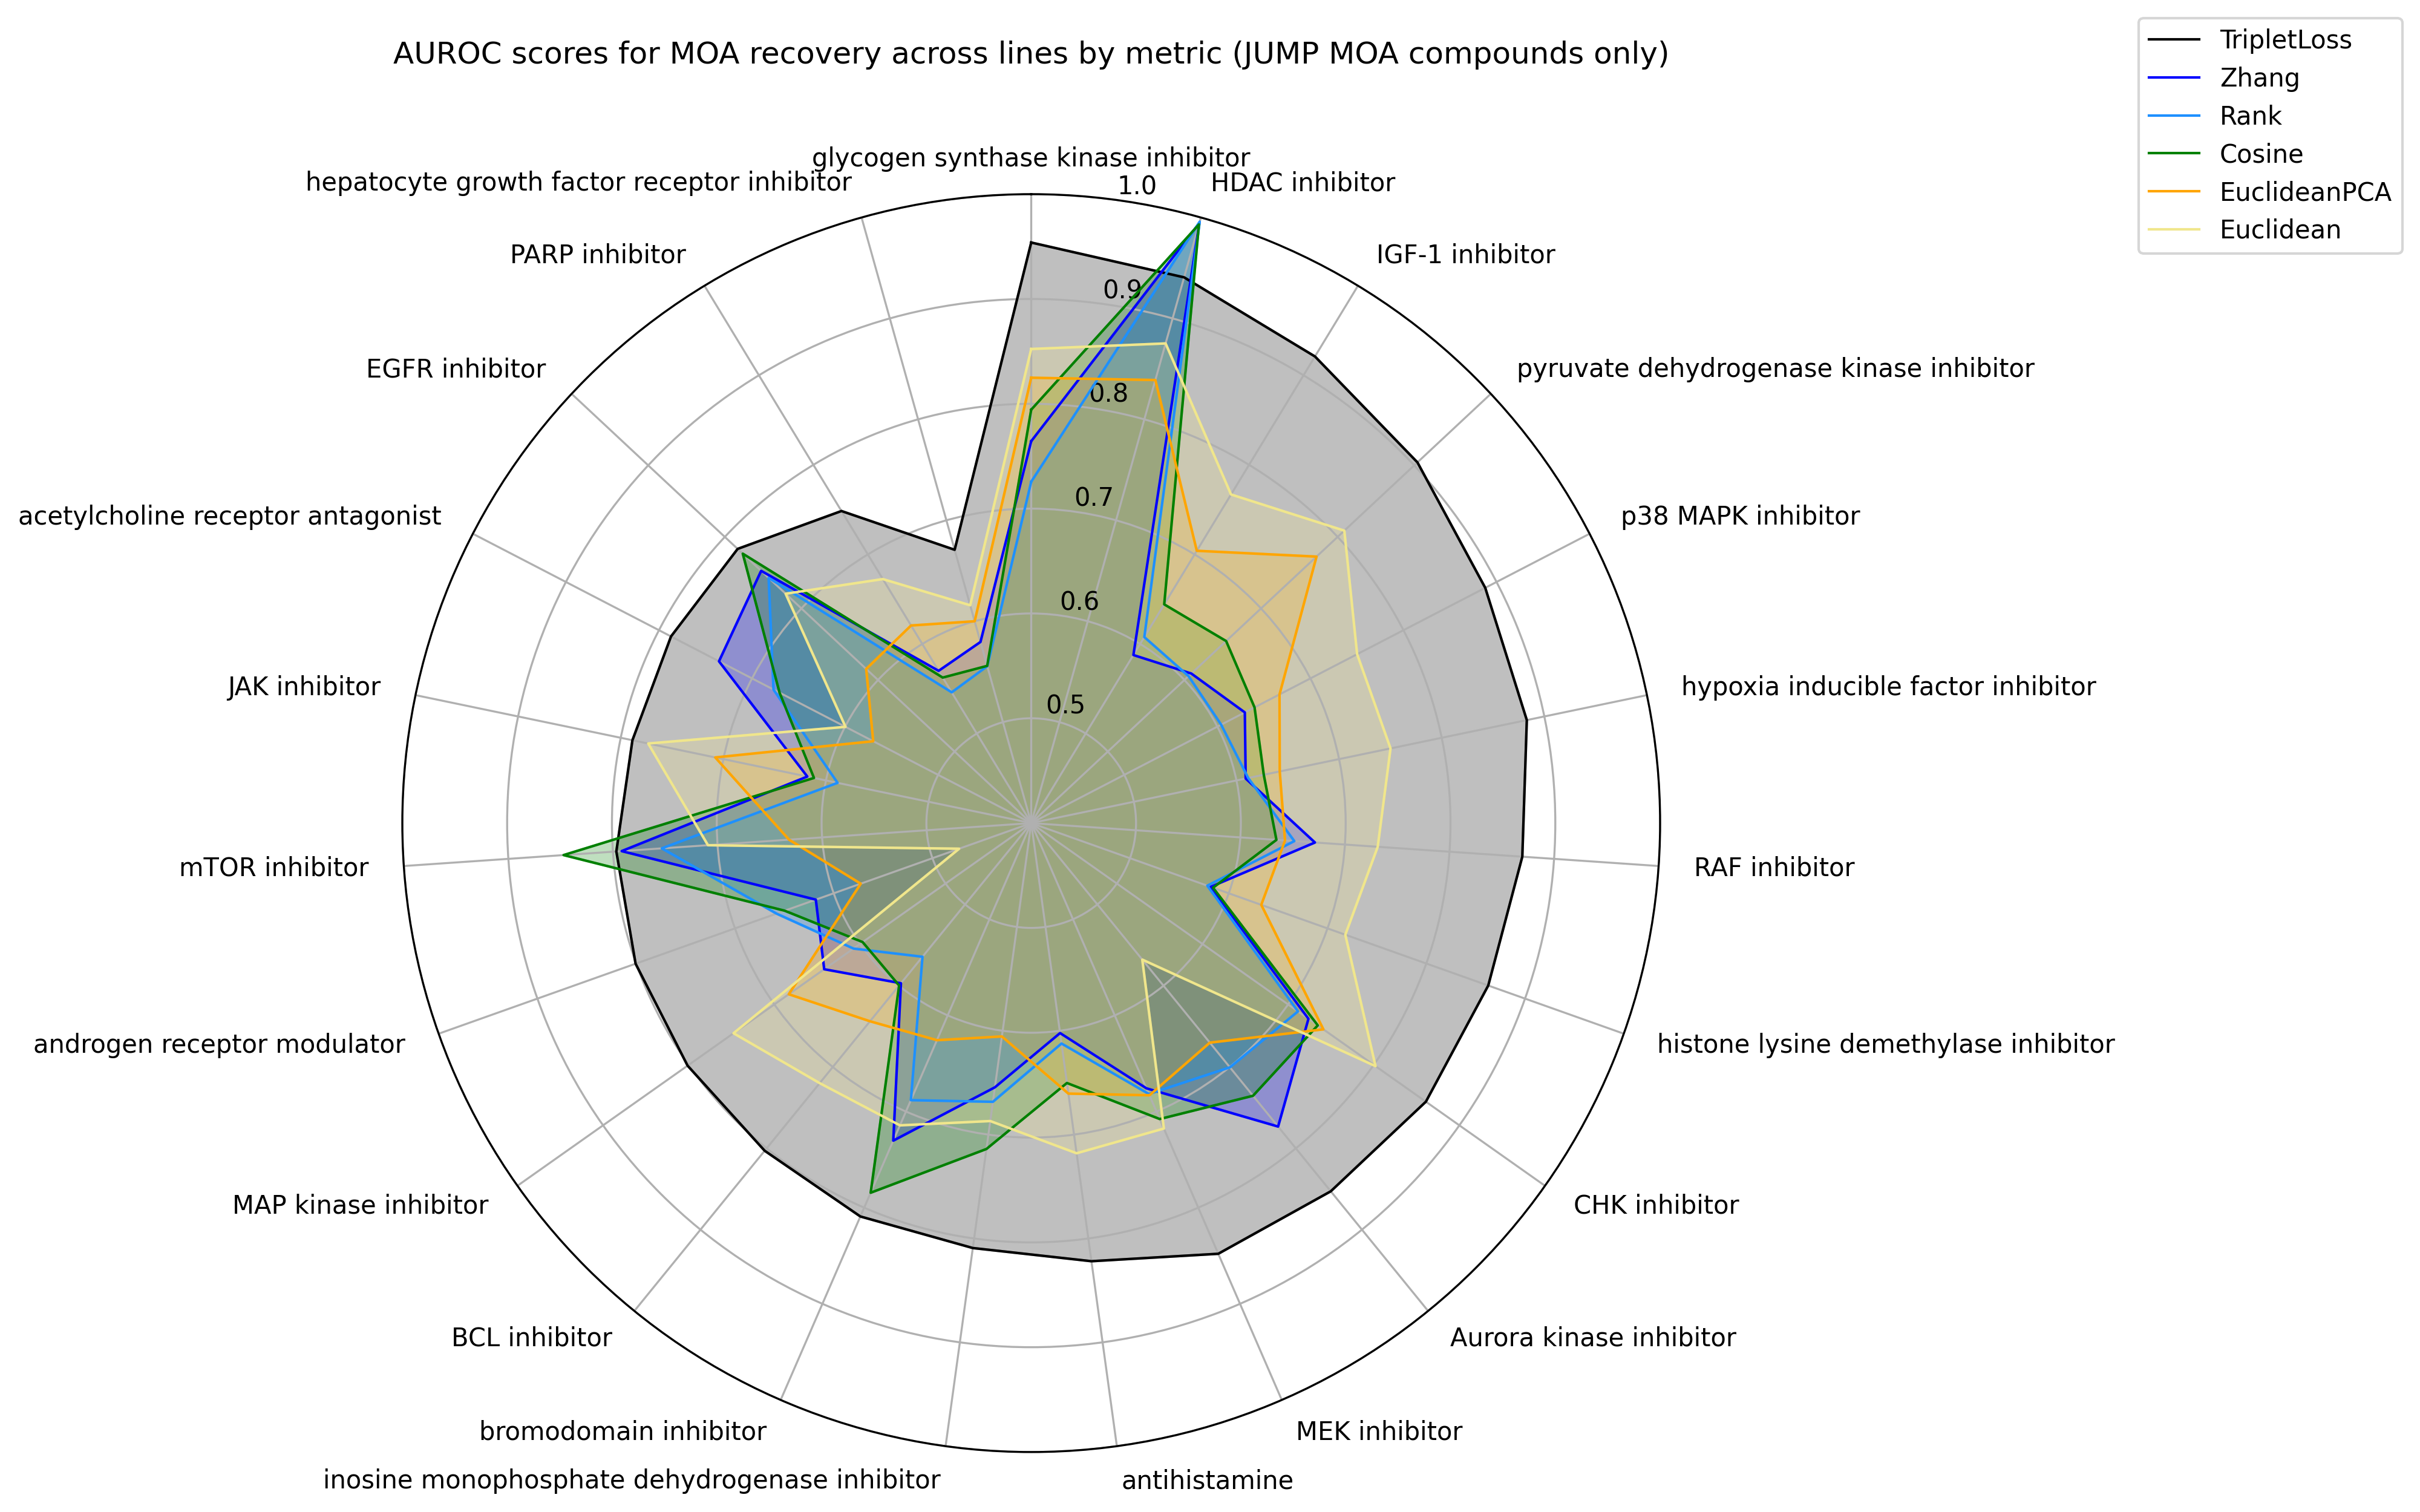

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from tqdm import tqdm



data_dir=Path("working_dir")/Path("plot_data")/Path("TripletLoss")/Path("155")/Path(f"uniquness_across_lines_moas")
files=list(data_dir.glob("auroc_*_jumpmoas_cls*_ps*.csv"))
print(files)
condensed_performance_df=pd.DataFrame()
for f in tqdm(files):
    df=pd.read_csv(f).rename(columns={'Unnamed: 0':'treatment'})
    df['metric']=f.stem.split("_")[1]
    df['cell_line_split']=f.stem.split("_")[3][-1]
    df['moa_split']=f.stem.split("_")[4][-1]
    condensed_performance_df=pd.concat([condensed_performance_df,df], ignore_index=True)
condensed_performance_df.to_csv(data_dir/f"summary_auroc_by_moa_jumpmoas_auroc_across_lines_moas.csv")

unique_treatments=condensed_performance_df.treatment.unique().tolist()
radial_df=pd.DataFrame()
for t in unique_treatments:
    for idx, row in condensed_performance_df.query("treatment==@t")[['trt_meanauroc','metric']].groupby("metric").agg("mean").sort_values("trt_meanauroc", ascending=False).iterrows():
        radial_df.loc[idx, t]=row['trt_meanauroc']
radial_df=radial_df.T.sort_values("TripletLoss", ascending=False).T
display(radial_df)
display(radial_df.loc["Euclidean",:])
radial_df.to_csv(data_dir/"plot_data_radial_auroc_jump_moa_compounds_and_moas.csv")
# Each attribute we'll plot in the radar chart.
labels = radial_df.columns.tolist()

values = radial_df.loc['TripletLoss'].tolist()

# Split the circle into even parts and save the angles
# so we know where to put each axis.
angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()

# The plot is a circle, so we need to "complete the loop"
# and append the start value to the end.
values += values[:1]
angles += angles[:1]

# ax = plt.subplot(polar=True)
fig, ax = plt.subplots(figsize=(16, 9), subplot_kw=dict(polar=True), dpi=300)

def add_to_radar(metric_name, color):
    values = radial_df.loc[metric_name].tolist()
    values += values[:1]
    ax.plot(angles, values, color=color, linewidth=1, label=metric_name)
    ax.fill(angles, values, color=color, alpha=0.25)


add_to_radar("TripletLoss", "k")
add_to_radar("Zhang", "b")
add_to_radar("Rank", "dodgerblue")
add_to_radar("Cosine", "g")
add_to_radar("EuclideanPCA", "orange")
add_to_radar("Euclidean", "khaki")

# Fix axis to go in the right order and start at 12 o'clock.
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
print(list(zip(np.degrees(angles), labels)))
print(len(angles), len(labels))
print(angles)
print(labels)

# Draw axis lines for each angle and label.
ax.set_thetagrids(np.degrees(angles[:-1]), labels)
for label, angle in zip(ax.get_xticklabels(), angles):
  if angle in (0, np.pi):
    label.set_horizontalalignment('center')
  elif 0 < angle < np.pi:
    label.set_horizontalalignment('left')
  else:
    label.set_horizontalalignment('right')

# Ensure radar goes from 0 to 100.
ax.set_ylim(0.4, 1)
# You can also set gridlines manually like this:
# ax.set_rgrids([20, 40, 60, 80, 100])

# Set position of y-labels (0-100) to be in the middle
# of the first two axes.
ax.set_rlabel_position(180 / len(labels))
ax.legend(loc='upper right', bbox_to_anchor=(1.6, 1.15))
ax.set_title("AUROC scores for MOA recovery across lines by metric (JUMP MOA compounds only)\n\n ")
fig.savefig(data_dir/"auroc_radial_plot.png", dpi=300,pad_inches=0, bbox_inches='tight')
fig.savefig(data_dir/"auroc_radial_plot.svg",pad_inches=0, bbox_inches='tight')
